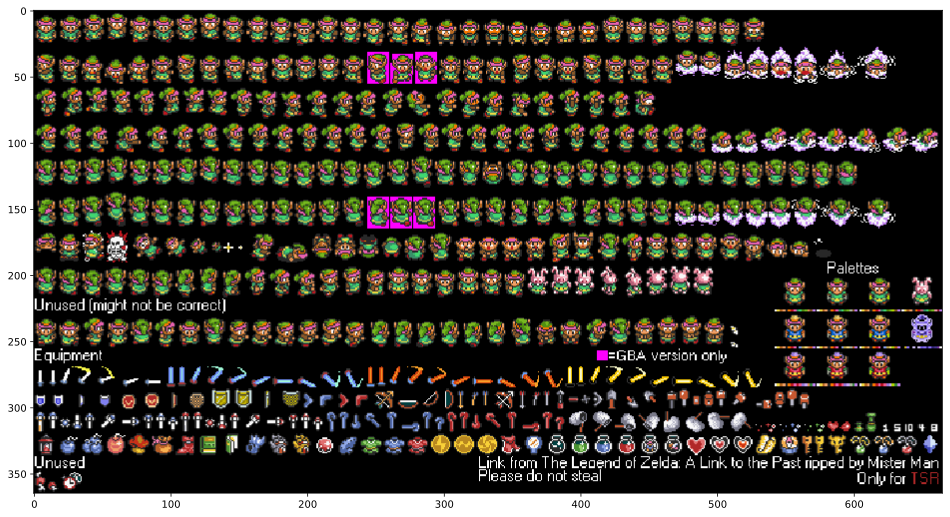

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


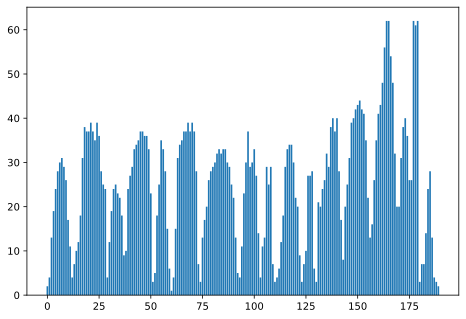

-------------------------
719
316
7
[{'length': 31, 'row': [5, 6, 3, 1, 7, 8, 4, 2, 9, 10, 14, 20, 11, 15, 21, 16, 22, 25, 26, 27, 29, 31, 28, 30, 12, 17, 23, 13, 18, 24, 19]}, {'length': 38, 'row': [46, 54, 55, 56, 57, 47, 58, 59, 67, 48, 60, 49, 61, 42, 50, 43, 62, 63, 68, 51, 52, 69, 53, 64, 65, 66, 36, 39, 37, 32, 33, 34, 38, 70, 71, 35, 72, 73]}, {'length': 39, 'row': [207, 196, 193, 192, 194, 208, 209, 210, 223, 211, 212, 224, 213, 197, 198, 199, 200, 214, 201, 202, 215, 216, 195, 217, 203, 204, 218, 225, 226, 219, 220, 205, 206, 231, 221, 232, 229, 222, 230]}, {'length': 40, 'row': [447, 448, 443, 422, 439, 464, 465, 424, 425, 426, 428, 440, 455, 456, 457, 449, 444, 429, 430, 431, 433, 441, 458, 459, 460, 451, 445, 434, 435, 436, 438, 442, 461, 462, 463, 453, 446, 399, 400, 401]}, {'length': 44, 'row': [500, 501, 502, 503, 504, 494, 495, 496, 469, 470, 477, 478, 497, 505, 498, 506, 479, 512, 480, 471, 481, 489, 482, 483, 484, 490, 485, 472, 509, 507, 491, 473, 510, 486, 487, 474

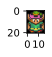

6


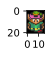

3


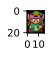

1


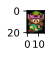

7


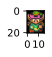

8


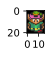

4


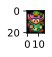

2


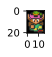

9


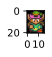

10


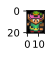

14


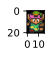

20


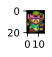

11


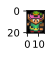

15


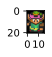

21


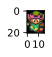

16


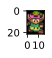

22


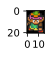

25


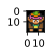

26


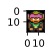

27


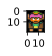

29


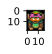

31


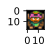

28


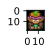

30


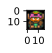

12


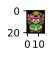

17


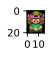

23


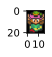

13


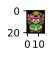

18


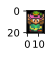

24


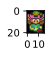

19


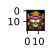

In [49]:
%config InlineBackend.figure_format = 'svg'
import os
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, data, filters
from skimage.viewer import ImageViewer
from skimage.exposure import histogram
from skimage.measure import label
from skimage.segmentation import flood, flood_fill
from scipy import ndimage
from scipy.ndimage.measurements import label
from PIL import Image
import cv2

# https://www.youtube.com/watch?v=TyWtx7q2D7Y
# Connected componenets

def scale_down(img, scalar):
    dims = img.shape
    height, length = dims[0], dims[1]
    return (length/scalar, height/scalar)

def show(img, scalar=1):
    if scalar:
        fig = plt.figure(figsize = scale_down(img, scalar))
    else:
        fig = plt.figure()
    io.imshow(img, aspect='auto')
    io.show()

def centroid(t1,t2):
    return (int(sum(t1)/2), int(sum(t2)/2))

# Todo refactor to check set of sets for largest then retrieve row
def unique(array, ignore=[0]):
    ignore = set(ignore)
    seen = set()
    u = []
    for a in array:
        if a not in seen and a not in ignore:
            seen.add(a)
            u.append(a)
    return u
            
def get_label_sets(labeled):
    # loop through rows
    # later allow for cols/groups
    label_sets = set()
    order_rows = []
    for row in labeled:
        clean_row = unique(row)
        frozen = frozenset(clean_row)
        if frozen not in label_sets:
            label_sets.add(frozen)
            if clean_row:
                order_rows.append({'length':len(clean_row), 'row': clean_row})
    return order_rows

img = io.imread('link.png')
background = flood(img[..., 0], (0,0), tolerance=0.0)
img[background] = 0
show(img, 50)
intback = np.invert(background).astype(int)
print(intback)


#show(intback,50)
#show(img[0:50,0:50],50)


structure = np.ones((3, 3), dtype=np.int)
labeled, ncomponents = label(intback, structure)

row_label_sets = get_label_sets(labeled)
x_vals = range(len(row_label_sets))
y_vals = [y['length'] for y in row_label_sets]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_vals,y_vals)
plt.show()

row_label_sets = sorted(row_label_sets, key=lambda k: k['row'][0]) 
#row_label_sets = sorted(row_label_sets, key=lambda k: k['length'], reverse=True)
#print(row_label_sets )
print('-------------------------')
seen = set()
max_ind, max_len = -1, 0
final_rows = []
for i,r in enumerate(row_label_sets):
    if r['length'] < max_len:
        row_set = set(row_label_sets[max_ind]['row'])
        if bool(seen & row_set):
            continue
        else:
            seen.update(row_set)
            final_rows.append(row_label_sets[max_ind])
            max_ind, max_len = -1, 0
    max_ind, max_len = i, r['length']

    
print(ncomponents)
print(len(seen))
print(len(final_rows))
print(final_rows)
            
# set_lengths = {}
# prev_len, max_ind = 0, 0 
# ordering = 0
# for i in range(len(row_label_sets)):
#     current = len(row_label_sets[i])
#     if current < prev_len:
#         set_lengths[ordering] = row_label_sets[max_ind]
#         ordering += 1
#     prev_len=current
#     max_ind = i
# print(set_lengths)
    
#show(labeled, 50)
clusters = []
# component_sort_dict = {}
#for n in range(ncomponents):
for n in final_rows[0]['row']:
    raw_inds = np.where(labeled==n)
    rrow, rcol = raw_inds
#     indices = zip(rrow, rcol)
#     indices = sorted(indices, key=lambda x:x[1])
#     indices = sorted(indices, key=lambda x:x[0])
#     least_index = indices[0]
    #component_sort_dict[n] = least_index
    minr, maxr = int(min(rrow)), int(max(rrow))
    minc, maxc = int(min(rcol)), int(max(rcol))
    comp_dict = {}
    comp_dict['index']= n
    comp_dict['row_tup'] = (minr, maxr+1)
    comp_dict['col_tup'] = (minc, maxc+1)
    comp_dict['point'] = (maxr,maxc)
    #comp_dict['point'] = centroid((minr, maxr+1),(minc, maxc+1))
    #comp_dict['point'] = least_index
    #comp_dict['img'] = img[minr:maxr+1,minc:maxc+1]
    #sub_image = img[minr:maxr+1,minc:maxc+1]
    #show(sub_image,50)
    clusters.append(comp_dict)
    
    
#clusters = sorted(clusters, key=lambda k: k['point'][1]) 
#clusters = sorted(clusters, key=lambda k: k['point'][0]) 
#clusters = sorted(clusters, key=lambda k: k['index'])




### POST SORT LOGIC ####
for c in clusters:
    print(c['index'])
    topleft, topright = c['row_tup']
    botleft, botright = c['col_tup']
    sub_image = img[topleft:topright,botleft:botright]
    #io.imsave(f'tmp/img{n}.png',sub_image)
    #print(c['point'])
    show(sub_image,50)
        

##### Sub Div stuff ######
# def get_diff_list(rows):
#     diffrows = [None]
#     for i in range(len(rows)-1):
#         if rows[i+1]-rows[i] ==1:
#             continue
#         else:
#             if diffrows[-1]!=rows[i]:
#                 diffrows.append(rows[i])
#             diffrows.append(rows[i+1])
#     return diffrows[1:]
    
# rows = []
# for row in range(len(img)):
#     num_colors = len(set(list(tuple(x) for x in img[row])))
#     if num_colors == 1:
#         rows.append(row)
# print(rows)

# diffrows = get_diff_list(rows)
# col_dict = {}
# for i in range(len(diffrows)-1):
#     up, down = diffrows[i],diffrows[i+1]
#     for col in range(len(img[0])):
#         num_colors = len(set(list(tuple(x) for x in img[up:down,col])))
#         if num_colors == 1:
#             if (up,down) not in col_dict:
#                 col_dict[(up,down)] = []
#             col_dict[(up,down)].append(col)
    
# for rbound in rows:
#     img[rbound,:] = 255
    
# for tup,col in col_dict.items():
#     up,down = tup
#     img[up:down,col] = 255

# row_dict = {}
# for tup in col_dict:
#     up,down = tup
#     bound_cols = get_diff_list(col_dict[tup])
#     for i in range(len(bound_cols)-1):
#         left,right = bound_cols[i], bound_cols[i+1]
#         for row in range(up,down+1):
#             num_colors = len(set(list(tuple(x) for x in img[row,left:right])))
#             if num_colors == 1:
#                 if row not in row_dict:
#                     row_dict[row] = []
#                 row_dict[row] = (left,right)
#                 #img[row,left:right] = 0

# for row,tup in row_dict.items():
#     left,right = tup
#     img[row,left:right] = 255
# show(img,50)

